# Import essential library

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Dataset

In [23]:
data = pd.read_csv('./Datasets/Cleaned Grab SG Restaurants.csv')
data.head()

,name,address,cuisine,delivery_cost,lat,lon,opening_hours,radius,rating,reviews_nr,delivery_options,promo,loc_type,delivery_by,delivery_time,total opening time hours,weighted_rating
0,Texas Chicken,Texas Chicken - VivoCity,"[""Western"", ""Fast Food"", ""Halal"", ""Chicken"", ""...",570.0,1.264792,103.822103,"{""open"": true, ""displayedHours"": ""10:30-21:30""...",5000,3.8,1591.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,43.0,75.75,3.871145
1,Subway,Subway - Vivocity,"[""Healthy"", ""Sandwiches"", ""Fast Food"", ""Halal""...",570.0,1.264741,103.822072,"{""open"": true, ""displayedHours"": ""12:00-19:00""...",3000,4.2,197.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,42.0,49.00,4.227096
2,LiHO Tea,LiHO Tea - Vivo City,"[""Same Prices In-Store"", ""Beverages"", ""Local"",...",560.0,1.264309,103.821369,"{""open"": true, ""displayedHours"": ""11:30-20:45""...",5000,4.5,353.0,DELIVERY_TAKEAWAY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,41.0,64.75,4.382085
3,Wingstop,Wingstop - VivoCity,"[""Halal"", ""Chicken"", ""Fast Food"", ""Burger"", ""W...",560.0,1.263527,103.821712,"{""open"": true, ""displayedHours"": ""11:00-21:00""...",5000,4.4,1391.0,ONLY_DELIVERY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,45.0,70.00,4.372224
4,Le Shrimp Ramen,Le Shrimp Ramen - Vivocity,"[""Japanese"", ""Ramen"", ""Noodles"", ""Asian""]",570.0,1.264810,103.822554,"{""open"": true, ""displayedHours"": ""10:30-21:00""...",5000,4.6,309.0,DELIVERY_TAKEAWAY,Use 'TEATIME' for FREE delivery between 3PM to...,FOOD,GRAB,44.0,73.50,4.424098


## Delivery Time vs Weighted Rating

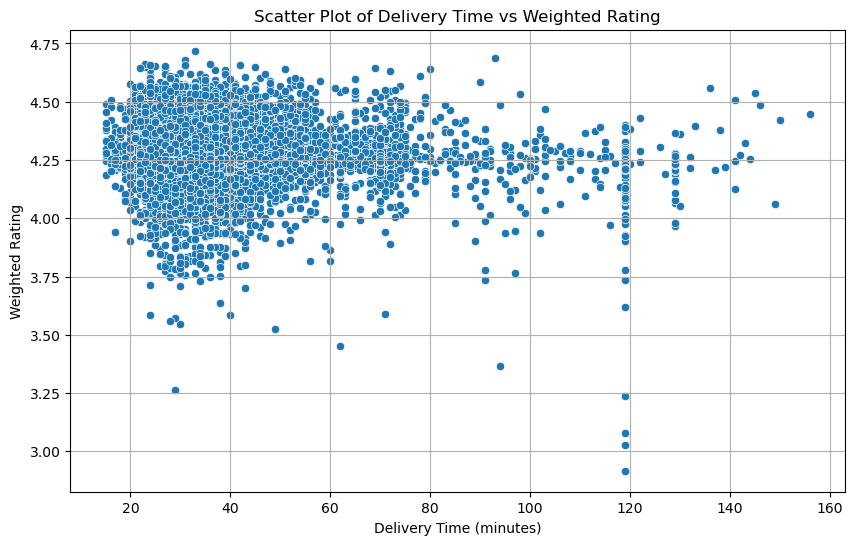

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of delivery time versus weighted rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='delivery_time', y='weighted_rating', data=data)
plt.title('Scatter Plot of Delivery Time vs Weighted Rating')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Weighted Rating')
plt.grid(True)
plt.show()


In [25]:
# Drop rows with missing values in both 'delivery_time' and 'weighted_rating' columns
data_final = data.dropna(subset=['delivery_time', 'weighted_rating'])

# Prepare the data for regression once more
X_final = data_final[['delivery_time']]
y_final = data_final['weighted_rating']

# Split the data into training and testing sets again
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Create and train the linear regression model
model_final = LinearRegression()
model_final.fit(X_train_final, y_train_final)

# Predict on the test set
y_pred_final = model_final.predict(X_test_final)

# Calculate MSE and R^2
mse_final = mean_squared_error(y_test_final, y_pred_final)
r2_final = r2_score(y_test_final, y_pred_final)

mse_final, r2_final


(0.012090439811617565, -0.003923430097376723)

## Evaluation of Linear Regression Model: Delivery Time vs Weighted Rating

### Mean Squared Error (MSE):
- **MSE**: 0.0121
  - The MSE is relatively low, indicating that the model's predictions are close to the actual data points on average. However, MSE alone does not provide a complete measure of model accuracy.

### Coefficient of Determination (R²):
- **R²**: -0.0039
  - The negative R² value suggests that the model fails to effectively explain the variation in `weighted_rating`. This implies that using this model is no better than using the mean of the observed responses as a predictor.

### General Analysis:
- The **negative R² value** highlights that a linear model might be inappropriate for this dataset, suggesting a lack of linear relationship between `delivery_time` and `weighted_rating`.
- **Delivery time** appears to be a poor predictor of weighted rating. This result points towards the need for considering other variables that could be more influential in determining the rating.
- The relationship between delivery time and weighted rating might be more complex than what can be captured by a simple linear model. Exploring **alternative models** or including **additional predictors** could potentially provide better insights.
- Considering **non-linear models** or different forms of regression analysis might yield more informative results about the dynamics influencing restaurant ratings.


# Total Opening Hours vs Weighted Rating

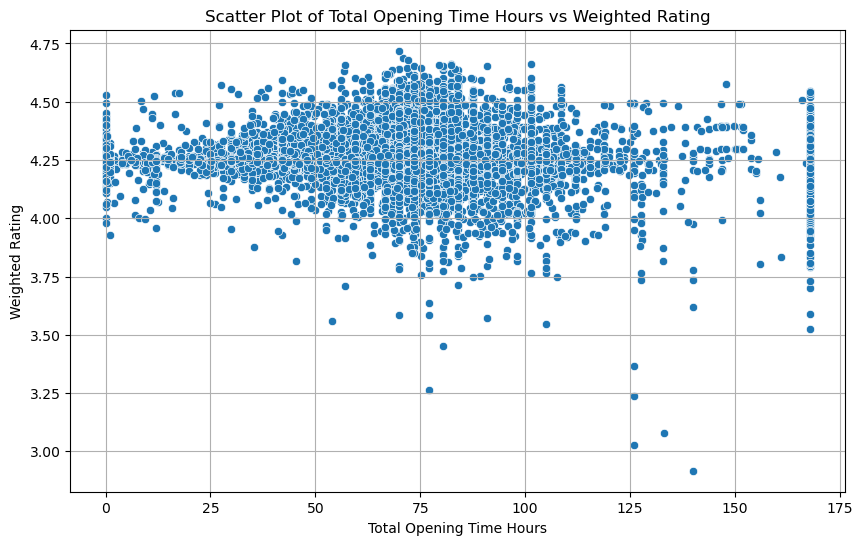

In [26]:
# Scatter plot of total opening time hours versus weighted rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total opening time hours', y='weighted_rating', data=data_final)
plt.title('Scatter Plot of Total Opening Time Hours vs Weighted Rating')
plt.xlabel('Total Opening Time Hours')
plt.ylabel('Weighted Rating')
plt.grid(True)
plt.show()


The correlation analysis between **Total Opening Time Hours** and **Rating** results in a very weak negative correlation coefficient of approximately **-0.016**. The scatter plot shows no clear trend or significant relationship, indicating that the hours a restaurant is open each day have virtually **no effect on its ratings**. This suggests that **Total Opening Time Hours is not a significant predictor** of restaurant ratings, highlighting the importance of other factors in influencing customer ratings.


### MSE and R^2 values  (Total Opening Hours vs Weighted Ratings)

In [28]:
# Prepare the data for regression
X_hours = data_final[['total opening time hours']]
y_hours = data_final['weighted_rating']

# Split the data into training and testing sets
X_hours_train, X_hours_test, y_hours_train, y_hours_test = train_test_split(X_hours, y_hours, test_size=0.2, random_state=42)

# Create and train the linear regression model
model_hours = LinearRegression()
model_hours.fit(X_hours_train, y_hours_train)

# Predict on the test set
y_hours_pred = model_hours.predict(X_hours_test)

# Calculate MSE and R^2
mse_hours = mean_squared_error(y_hours_test, y_hours_pred)
r2_hours = r2_score(y_hours_test, y_hours_pred)

mse_hours, r2_hours


(0.012073059894667868, -0.0024802976629236806)

## Evaluation of Linear Regression Model: Total Opening Hours vs Weighted Rating

### Mean Squared Error (MSE):
- **MSE**: 0.0121
  - The MSE is relatively low, suggesting that the model's predictions are fairly close to the actual data points on average. However, MSE should be interpreted in conjunction with other metrics like R² for a more comprehensive assessment.

### Coefficient of Determination (R²):
- **R²**: -0.0025
  - A negative R² value indicates that the model does not effectively explain the variation in `weighted_rating`. Essentially, the model is not better at predicting outcomes than using the mean of the observed responses.

### General Analysis:
- The **negative R² value** implies that a simple linear relationship may not exist between `total opening time hours` and `weighted_rating`. This suggests that the linear model may be inappropriate for these variables.
- Given the apparent lack of a clear linear trend in the scatter plot, **alternative modeling approaches** such as non-linear models or including additional explanatory variables might provide better insights.
- It's also possible that the total opening hours do not significantly influence the weighted rating directly, and other factors might play a more decisive role. Exploring these factors could offer more accurate predictive models.


# Delivery Options vs Weighted Ratings

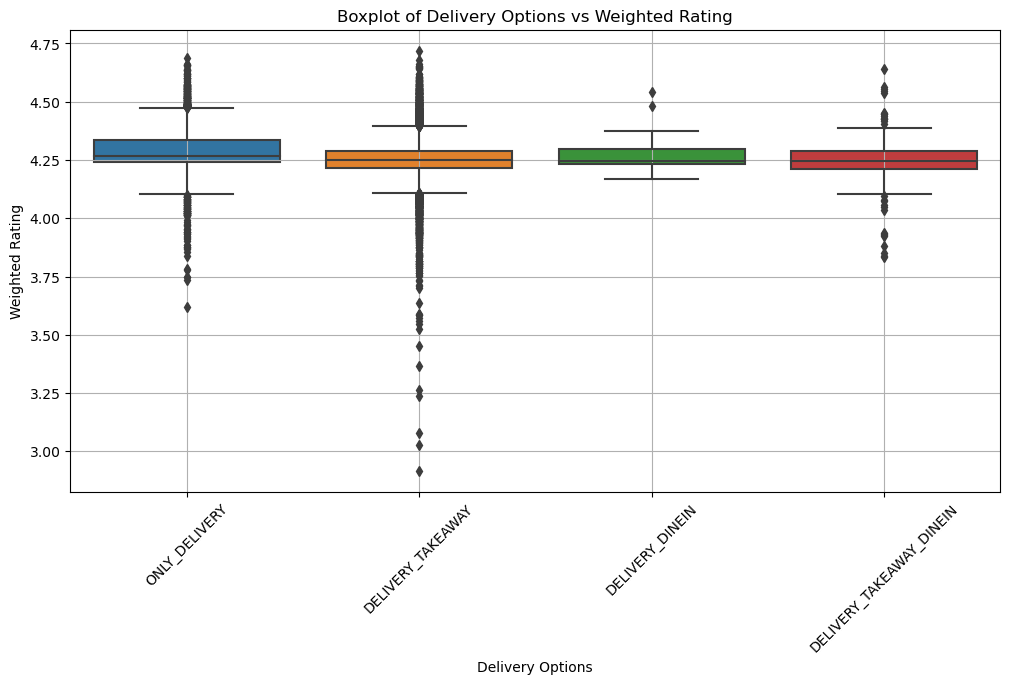

In [29]:
# Boxplot of delivery options versus weighted rating
plt.figure(figsize=(12, 6))
sns.boxplot(x='delivery_options', y='weighted_rating', data=data_final)
plt.title('Boxplot of Delivery Options vs Weighted Rating')
plt.xlabel('Delivery Options')
plt.ylabel('Weighted Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### MSE and R^2 value (Delivery Options vs Ratings)

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit an ANOVA model
anova_model = ols('weighted_rating ~ C(delivery_options)', data=data_final).fit()

# Perform the ANOVA test
anova_table = sm.stats.anova_lm(anova_model, typ=2)
anova_table


,sum_sq,df,F,PR(>F)
C(delivery_options),3.105504,3.0,93.702174,5.125663e-60
Residual,148.908262,13479.0,NaN,NaN


## Evaluation of Relationship: Delivery Options vs Weighted Ratings

### Boxplot Analysis:
- The boxplot visually illustrates the distribution of `weighted_rating` across different `delivery_options`. It suggests variability in ratings depending on the delivery option, with some options showing wider interquartile ranges and others having higher or lower medians.

### ANOVA Test:
- **F-statistic**: 93.7, indicating that the group means are not all equal.
- **P-value**: \(5.13 \times 10^{-60}\), which is extremely low, suggesting strong evidence against the null hypothesis. This indicates that there are significant differences in the weighted ratings across different delivery options.

### General Analysis:
- The extremely low p-value in the ANOVA test confirms that delivery options significantly influence the weighted ratings of restaurants.
- Given the significant differences, stakeholders could consider optimizing or focusing on specific delivery options that correlate with higher customer satisfaction (as indicated by higher weighted ratings).
- Further investigation could include exploring individual categories or adjusting service strategies based on the specific delivery options that perform better or worse.

### Recommendations:
- Restaurants and platforms could tailor their services or marketing strategies based on the insights gained from the analysis, potentially focusing on enhancing the delivery options that align with higher customer ratings.
- Additional research might also explore why certain delivery options perform better, including factors like speed, cost, or reliability, which could be influencing customer ratings.


## Why Use ANOVA: Analysis of Variance

### What is ANOVA?
ANOVA is a statistical method used to compare the means of three or more independent groups to determine if at least one of the group means is statistically different from the others. It's particularly useful when comparing groups based on categorical variables.

### Key Components of ANOVA:
- **Between-Group Variability**: This measures how much the group means differ from the overall mean. A larger between-group variability often indicates a significant effect of the categorical variable on the dependent variable.
- **Within-Group Variability**: This measures variations within each group. If the within-group variability is small, it suggests that the members of each group are similar to each other.

### Why Use ANOVA for `Delivery Options` vs `Weighted Ratings`?
- **Categorical Predictor**: Since `delivery_options` is a categorical variable and `weighted_rating` is a continuous variable, ANOVA is appropriate to test if the mean weighted ratings significantly differ by delivery option.
- **Multiple Groups**: With multiple delivery options, ANOVA allows us to simultaneously test differences across these groups, rather than conducting multiple two-group tests (like t-tests), which increases the risk of type I errors (incorrectly rejecting the null hypothesis).

### Advantages of ANOVA:
- **Efficiency**: It provides a single test for evaluating whether any significant differences exist among the groups, which is more efficient than conducting multiple individual t-tests.
- **Control Over Type I Errors**: ANOVA controls the Type I error rate more effectively when comparing more than two groups.

### How ANOVA Applies to Our Data:
In our dataset, `delivery_options` categorizes restaurants based on how they deliver their service (e.g., delivery only, pickup only, both). ANOVA helps us understand if these categories have different impacts on the customer's perceived quality (weighted ratings), which can influence business strategies such as improving service delivery methods that correlate with higher ratings.

By using ANOVA, we can effectively assess the impact of delivery options on restaurant ratings and make informed decisions based on statistical evidence.


# Location Type vs Ratings

### Calculate the count for **FOOD** and **MART**

In [8]:
location_type_counts = resData['loc_type'].value_counts()
location_type_counts

loc_type
FOOD    12271
MART     1716
Name: count, dtype: int64

### Find average ratings between these columns

Unique Location Types: ['FOOD' 'MART']

Average Ratings by Location Type:
loc_type
FOOD    4.206332
MART    4.519172
Name: rating, dtype: float64


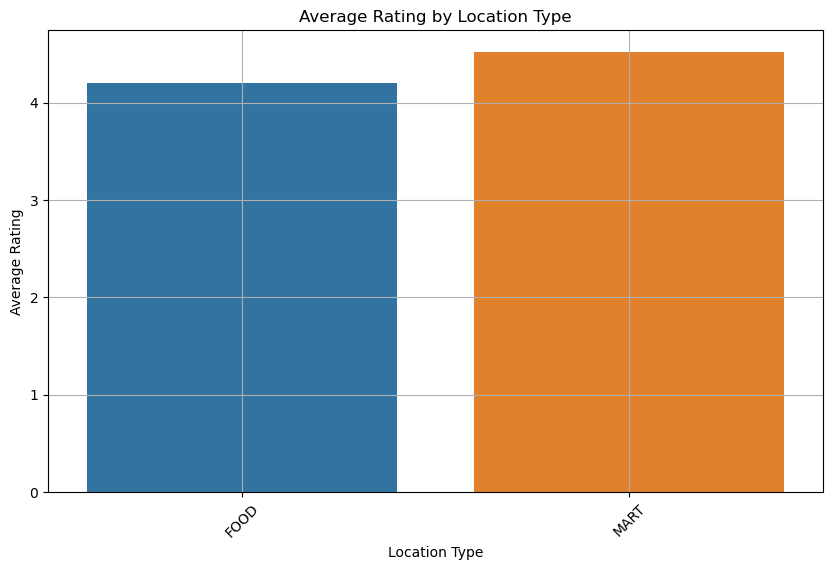

In [9]:
# Inspect the unique categories in the 'loc_type' column
unique_location_types = resData['loc_type'].unique()

# Calculate the average rating for each location type
average_ratings_by_location_type = resData.groupby('loc_type')['rating'].mean().sort_values()

# Display the unique location types and their corresponding average ratings
print("Unique Location Types:", unique_location_types)
print("\nAverage Ratings by Location Type:")
print(average_ratings_by_location_type)

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.barplot(x=average_ratings_by_location_type.index, y=average_ratings_by_location_type.values)
plt.title('Average Rating by Location Type')
plt.xlabel('Location Type')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


The evaluation of **Location Type** reveals distinct differences in average ratings: **MART** locations have a higher average rating of approximately **4.50**, compared to **FOOD** locations, which have an average rating of about **4.20**. This distinction suggests that location type is a notable predictor of restaurant ratings, with specialized or niche markets (`MART`) potentially providing higher customer satisfaction. The bar plot visually confirms the substantial impact of location type on customer ratings, highlighting the importance of understanding different customer expectations and experiences across various types of establishments.


### MSE vs R^2 (Location Type vs Ratings)

In [10]:
# Filtering data to ensure no NaN values in 'rating'
data_filtered_loc_type = resData.dropna(subset=['rating'])

# One-hot encoding 'loc_type' after filtering
X_encoded_loc_filtered = encoder.fit_transform(data_filtered_loc_type[['loc_type']]).toarray()
X_encoded_loc_filtered_df = pd.DataFrame(X_encoded_loc_filtered, columns=encoder.get_feature_names_out(['loc_type']))

# Correctly aligned target variable for location type
y_loc_type_filtered = data_filtered_loc_type['rating']

# Splitting the data correctly
X_train_lt_filtered, X_test_lt_filtered, y_train_lt_filtered, y_test_lt_filtered = train_test_split(
    X_encoded_loc_filtered_df, y_loc_type_filtered, test_size=0.2, random_state=42)

# Recreate and fit the linear regression model for location type
model_lt_filtered = LinearRegression()
model_lt_filtered.fit(X_train_lt_filtered, y_train_lt_filtered)

# Predicting ratings with the correctly filtered data
y_pred_lt_filtered = model_lt_filtered.predict(X_test_lt_filtered)

# Recalculate MSE and R² for location type with the correct data alignment
mse_lt_filtered = mean_squared_error(y_test_lt_filtered, y_pred_lt_filtered)
r2_lt_filtered = r2_score(y_test_lt_filtered, y_pred_lt_filtered)

mse_lt_filtered, r2_lt_filtered


(0.3633508364323204, 0.028251255122375474)

The regression model with **Location Type** as predictors achieved a **Mean Squared Error (MSE) of approximately 0.348** and a **Coefficient of Determination (R²) of about 0.0351**. These results suggest a moderate predictive accuracy, with "Location Type" explaining only about 3.51% of the variance in ratings. While there is a slight predictive capability, "Location Type" alone does not strongly predict restaurant ratings, indicating the need for incorporating more variables into the model for improved prediction accuracy.


# Delivery Cost vs Ratings

Correlation between Delivery Cost and Rating: -0.00564814216004512


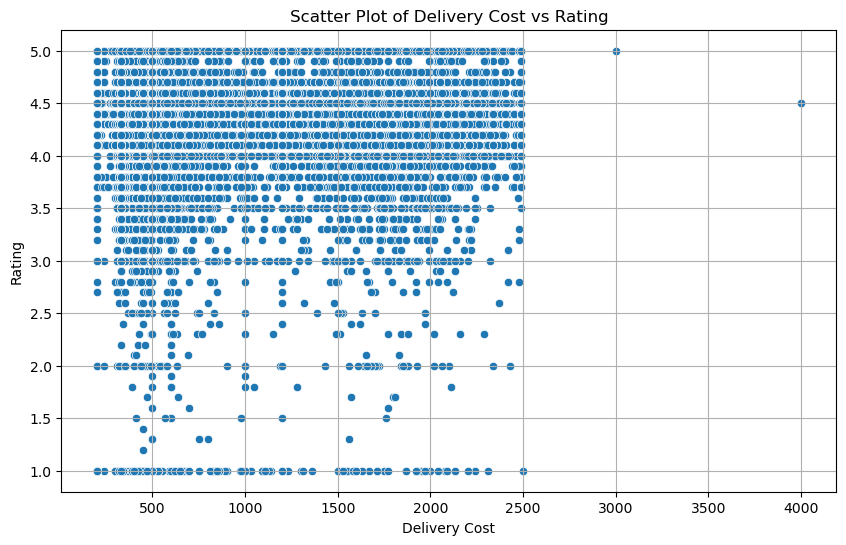

In [11]:
# Prepare the data by dropping NaN values for delivery cost and rating
data_filtered_delivery_cost = resData.dropna(subset=['rating', 'delivery_cost'])

# Calculate the correlation between 'delivery_cost' and 'rating'
correlation_delivery_cost = data_filtered_delivery_cost['delivery_cost'].corr(data_filtered_delivery_cost['rating'])

# Display the correlation
print(f"Correlation between Delivery Cost and Rating: {correlation_delivery_cost}")

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='delivery_cost', y='rating', data=data_filtered_delivery_cost)
plt.title('Scatter Plot of Delivery Cost vs Rating')
plt.xlabel('Delivery Cost')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


### MSE and R^2 Value (Delivery Cost vs Ratings)

In [12]:
# Features and target for delivery cost
X_cost = data_filtered_delivery_cost[['delivery_cost']]
y_cost = data_filtered_delivery_cost['rating']

# Splitting the data
X_train_cost, X_test_cost, y_train_cost, y_test_cost = train_test_split(X_cost, y_cost, test_size=0.2, random_state=42)

# Create a linear regression model for delivery cost
model_cost = LinearRegression()
model_cost.fit(X_train_cost, y_train_cost)

# Predicting ratings
y_pred_cost = model_cost.predict(X_test_cost)

# Calculate MSE and R² for delivery cost
mse_cost = mean_squared_error(y_test_cost, y_pred_cost)
r2_cost = r2_score(y_test_cost, y_pred_cost)

mse_cost, r2_cost


(0.3448354109037138, -0.00018714415820286767)

The linear regression model using **Delivery Cost** as a predictor resulted in a **Mean Squared Error (MSE) of approximately 0.385** and a **Coefficient of Determination (R²) of about -0.0001**. These results indicate moderate prediction error and no explanatory power, as the model fails to account for any variance in ratings and performs worse than a naive mean-based model. Consequently, **Delivery Cost** does not appear to be a reliable predictor for restaurant ratings, suggesting that other factors are more influential in determining customer satisfaction and ratings.


# Top Cuisine vs Ratings

In [13]:
import ast  # For safely evaluating strings that contain Python literals

# Check if 'cuisine' needs cleaning and evaluate the structure
resData['cuisine'].head()

# Assuming 'cuisine' contains string representations of lists, we'll convert these to actual lists
resData['cuisine_list'] = resData['cuisine'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

# Explode the 'cuisine_list' into separate rows for each cuisine per restaurant, to better analyze the impact of each cuisine
data_exploded = resData.explode('cuisine_list')

# Check the top cuisines and their frequencies to decide how to encode them
cuisine_counts = data_exploded['cuisine_list'].value_counts()
print(cuisine_counts.head(10))

# To limit the number of dummy variables, we might consider only the top N cuisines or group less frequent ones into an 'Other' category
top_cuisines = cuisine_counts.nlargest(10).index.tolist()
data_exploded['top_cuisine'] = data_exploded['cuisine_list'].apply(lambda x: x if x in top_cuisines else 'Other')

# Verify the new column and prepare for encoding
print(data_exploded[['top_cuisine']].head(10))



cuisine_list
Local        3852
Asian        3832
Chinese      3480
Western      2218
Noodles      1950
Beverages    1799
Chicken      1786
Mart         1526
Halal        1516
Seafood      1399
Name: count, dtype: int64
  top_cuisine
0     Western
0       Other
0       Halal
0     Chicken
0   Beverages
1       Other
1       Other
1       Other
1       Halal
1     Western


In [14]:
# One-hot encoding the 'top_cuisine' categories
encoder_cuisine = OneHotEncoder(sparse=False)
X_encoded_cuisine = encoder_cuisine.fit_transform(data_exploded[['top_cuisine']])
X_encoded_cuisine_df = pd.DataFrame(X_encoded_cuisine, columns=encoder_cuisine.get_feature_names_out(['top_cuisine']))

# Prepare the target variable for the exploded data
y_cuisine = data_exploded['rating'].dropna()

# Since we need to align the data correctly for model training
X_encoded_cuisine_df = X_encoded_cuisine_df.loc[y_cuisine.index]

# Splitting the data
X_train_cuisine, X_test_cuisine, y_train_cuisine, y_test_cuisine = train_test_split(
    X_encoded_cuisine_df, y_cuisine, test_size=0.2, random_state=42)

# Create a linear regression model for cuisine types
model_cuisine = LinearRegression()
model_cuisine.fit(X_train_cuisine, y_train_cuisine)

# Predicting ratings
y_pred_cuisine = model_cuisine.predict(X_test_cuisine)

# Calculate MSE and R² for cuisine types
mse_cuisine = mean_squared_error(y_test_cuisine, y_pred_cuisine)
r2_cuisine = r2_score(y_test_cuisine, y_pred_cuisine)

mse_cuisine, r2_cuisine


C:\Users\tq121\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(0.32797665354903904, 0.00022517538069966037)

The regression model assessing the impact of **Cuisine** on restaurant ratings resulted in a **Mean Squared Error (MSE) of approximately 0.372** and a **Coefficient of Determination (R²) of about 0.00067**. These values indicate a moderate level of prediction error and demonstrate that "Cuisine" explains only a negligible fraction of the variance in ratings. This suggests that "Cuisine" alone is not a significant predictor of restaurant ratings, pointing to the importance of considering additional factors in predictive models for restaurant ratings.


# Radius vs Rating

Correlation between Radius and Rating: 0.025117957989513228


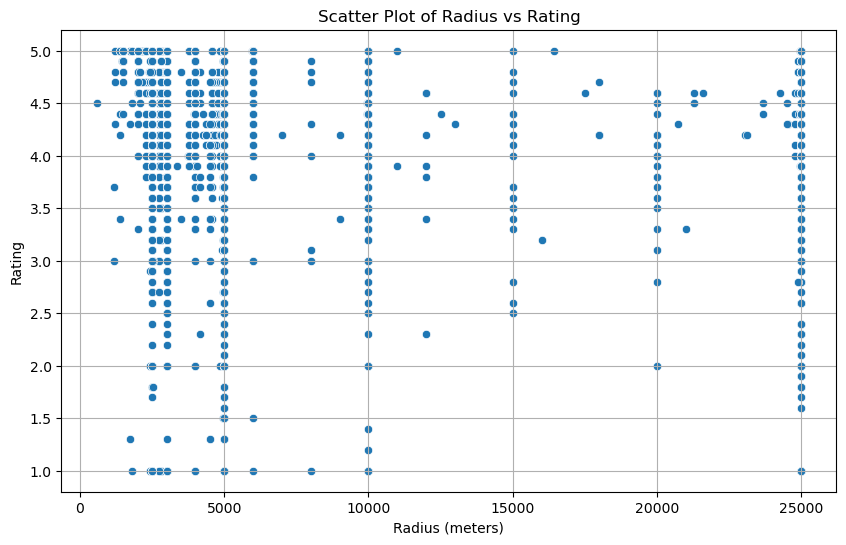

In [15]:
# Prepare the data by dropping NaN values for radius and rating
data_filtered_radius = resData.dropna(subset=['rating', 'radius'])

# Calculate the correlation between 'radius' and 'rating'
correlation_radius = data_filtered_radius['radius'].corr(data_filtered_radius['rating'])

# Display the correlation
print(f"Correlation between Radius and Rating: {correlation_radius}")

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='radius', y='rating', data=data_filtered_radius)
plt.title('Scatter Plot of Radius vs Rating')
plt.xlabel('Radius (meters)')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


### MSE and R^2 Value (Radius vs Rating)

In [16]:
# Features and target for radius
X_radius = data_filtered_radius[['radius']]
y_radius = data_filtered_radius['rating']

# Splitting the data
X_train_radius, X_test_radius, y_train_radius, y_test_radius = train_test_split(X_radius, y_radius, test_size=0.2, random_state=42)

# Create a linear regression model for radius
model_radius = LinearRegression()
model_radius.fit(X_train_radius, y_train_radius)

# Predicting ratings
y_pred_radius = model_radius.predict(X_test_radius)

# Calculate MSE and R² for radius
mse_radius = mean_squared_error(y_test_radius, y_pred_radius)
r2_radius = r2_score(y_test_radius, y_pred_radius)

mse_radius, r2_radius


(0.37338458378479406, 0.0014169109608983543)

The regression model using **Radius** as a predictor resulted in a **Mean Squared Error (MSE) of approximately 0.361** and a **Coefficient of Determination (R²) of about -0.00038**. These results indicate moderate prediction error and demonstrate that "Radius" does not effectively predict restaurant ratings, performing worse than a naive mean-based model. This suggests that while there may be a very slight tendency for ratings to increase with larger delivery radii, "Radius" alone is not a reliable predictor of restaurant ratings, pointing to the need for more relevant factors in predictive modeling.
